In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sym
from jax import jit
h=0.001
D=np.eye(2)*401
x=[0,1,0]
y=[0,0,1]


L = 0.02
m = 10
n = 10
point_num = m * n

x = np.linspace(0, L, n)
y = np.linspace(0, L, m)

grid = np.meshgrid(x, y)

points = np.zeros((point_num, 2))
for i in range(point_num):
    points[i, 0], points[i, 1] = grid[0].flatten()[i], grid[1].flatten()[i]
    
# Storing the points that form a cell in an array (1. points opposing the hypothenuse, numbering counterclockwise)
cells = np.zeros(((n-1)*(m-1)*2, 3), dtype=np.int16)
j = 0
for i in range((n-1)*(m-1)*2):
    if i % 2 == 0:
        cells[i][0], cells[i][1], cells[i][2] = j, j + 1, j + n
        j += n + 1
    else:
        cells[i][0], cells[i][1], cells[i][2] = j, j - 1, j - n
        if (i + 1) % (2 * (n - 1)) == 0:
            j = j - n + 1
        else:
            j -= n
    
def KE(x,y,D,t):
    J=np.asarray([[x[0]-x[2],y[0]-y[2]],[x[1]-x[2],y[1]-y[2]]])
    Be=1/np.linalg.det(J)*np.asarray([[J[1,1],0,-J[0,1],0,J[1,1]-J[0,1],0],[0,-J[1,0],0,J[0,0],0,J[1,0]-J[0,0]],[-J[1,0],J[1,1],J[0,0],-J[0,1],J[1,0]-J[0,0],J[0,1]-J[1,1]]])
    Ke=0.5*np.linalg.det(J)*t*np.transpose(Be)*D*Be
    return Ke


#for i in range(len(cells)):
    #x1,x2,x3=points[cells[i]][0][0],points[cells[i]][0][1],points[cells[i]][0][2]
    #y1,y2,y3=points[cells[i]][1][0],points[cells[i]][1][1],points[cells[i]][1][2]
    #b1,b2,b3=y2-y3,y3-y1,y1-y2
    #c1,c2,c3=x3-x2,x1-x3,x2-x1
    #delta=(x1*b1+x2*b2+x3*b3)/2
    #He=[[b1*b1,b1*b2,b1*b3],[b2*b1,b2*b2,b2*b3],[b3*b1,b3*b2,b3*b3]]+[[c1*c1,c2*c1,c3*c1],[c2*c1,c2*c2,c3*c2],[c3*c1,c3*c2,c3*c3]]
    #He=He*401*h/delta
    #T=np.zeros((3,100))
    #T[0,cells[i,0]]=1
    #T[1,cells[i,1]]=1
    #T[2,cells[i,2]]=1
    #T_trans=np.transpose(T)
    #add=T_trans@Kl@T
    #glo+=add

#print(KE(x,y,D,t))
#shape function ll triangle:
s=sym.symbols('s');t=sym.symbols('t')
N1l=(1-s-t)/2
N2l=(s)/2
N3l=(t)/2



#shape function ur triangle:
N1u=(1-t)/2
N2u=(-1+s+t)/2
N3u=(1-s)/2

dN1ls=sym.diff(N1l,s)
dN1lt=sym.diff(N1l,t)
dN2ls=sym.diff(N2l,s)
dN2lt=sym.diff(N2l,t)
dN3ls=sym.diff(N3l,s)
dN3lt=sym.diff(N3l,t)
dN1us=sym.diff(N1u,s)
dN1ut=sym.diff(N1u,t)
dN2us=sym.diff(N2u,s)
dN2ut=sym.diff(N2u,t)
dN3us=sym.diff(N3u,s)
dN3ut=sym.diff(N3u,t)
STl=sym.Matrix([[dN1ls,dN2ls,dN3ls],[dN1lt,dN2lt,dN3lt]])
STu=sym.Matrix([[dN1us,dN2us,dN3us],[dN1ut,dN2ut,dN3ut]])
k_mat=D
element=[]
for i in range(len(cells)):
    a,b,c=points[cells[i][0]],points[cells[i][1]],points[cells[i][2]]
    temp=(np.concatenate((a,b,c),axis=0))
    element.append(temp)
#print(np.asarray(element))

xstl=(element[0][0]*N1l)+(element[0][2]*N2l)+(element[0][4]*N3l)
xstu=(element[0][0]*N1u)+(element[0][2]*N2u)+(element[0][4]*N3u)
ystl=(element[1][1]*N1l)+(element[1][3]*N2l)+(element[1][5]*N3l)
ystu=(element[1][1]*N1u)+(element[1][3]*N2u)+(element[1][5]*N3u)
Jl=sym.Matrix([[sym.diff(xstl,s),sym.diff(ystl,s)],[sym.diff(xstl,t),sym.diff(ystl,t)]])
Ju=sym.Matrix([[sym.diff(xstu,s),sym.diff(ystu,s)],[sym.diff(xstu,t),sym.diff(ystu,t)]])
#print(Jl,Ju)
Jl_inv=Jl.inv()
Ju_inv=Ju.inv()
Jl_det=Jl.det()
Ju_det=Ju.det()
XTl=Jl_inv*STl
XTu=Ju_inv*STu
XTl_trans=XTl.transpose()
XTu_trans=XTu.transpose()
KEl=sym.Matrix(3,3,XTl_trans*k_mat*XTl*Jl_det*h)
KEu=sym.Matrix(3,3,XTu_trans*k_mat*XTu*Ju_det*h)
print(KEl,KEu)
Kl=sym.zeros(3,3)
Ku=sym.zeros(3,3)
for i in range(3):
    for j in range(3):
        Kl[i,j]=sym.integrate(KEl[i,j],(t,-1,1),(s,-1,1))
        Ku[i,j]=sym.integrate(KEu[i,j],(t,-1,1),(s,-1,1))
print(Kl)
print(Ku)
#glo=np.zeros((100,100))
#@jit
for i in range(len(cells)):
    T=np.zeros((3,100))
    T[0,cells[i,0]]=1
    T[1,cells[i,1]]=1
    T[2,cells[i,2]]=1
    T_trans=np.transpose(T)
    #add=T_trans@Kl@T
    #glo+=add
#glo=-glo
#print(glo)
#glo=np.asarray(glo)

T1_10=np.ones(10)*373
Q11_100=np.zeros(90)
Q11_100[80:]=-1500000
Hul=glo[0:10,0:10]
Hur=glo[10:,0:10]
Hll=glo[0:10,10:]
Hlr=glo[10:,10:]
print(type(Hul),type(T1_10))

b=Q11_100-T1_10@Hll
print(b)
T11_100=np.linalg.solve(Hlr,b)
print(T11_100)

Matrix([[-0.200500000000000, 0.100250000000000, 0.100250000000000], [0.100250000000000, -0.100250000000000, 0], [0.100250000000000, 0, -0.100250000000000]]) Matrix([[-0.200500000000000, 0.100250000000000, 0.100250000000000], [0.100250000000000, -0.100250000000000, 0], [0.100250000000000, 0, -0.100250000000000]])
Matrix([[-0.802000000000000, 0.401000000000000, 0.401000000000000], [0.401000000000000, -0.401000000000000, 0], [0.401000000000000, 0, -0.401000000000000]])
Matrix([[-0.802000000000000, 0.401000000000000, 0.401000000000000], [0.401000000000000, -0.401000000000000, 0], [0.401000000000000, 0, -0.401000000000000]])


NameError: name 'glo' is not defined

In [52]:
glo=np.zeros((100,100))

for i in range(len(cells)):
    x1,x2,x3=points[cells[i]][0][0],points[cells[i]][1][0],points[cells[i]][2][0]
    y1,y2,y3=points[cells[i]][0][1],points[cells[i]][1][1],points[cells[i]][2][1]
    b1,b2,b3=y2-y3,y3-y1,y1-y2
    c1,c2,c3=x3-x2,x1-x3,x2-x1
    delta=(x1*b1+x2*b2+x3*b3)/2
    factor=np.array(401*h/(4*delta))
    He=np.array([[b1*b1,b1*b2,b1*b3],[b2*b1,b2*b2,b2*b3],[b3*b1,b3*b2,b3*b3]])+np.array([[c1*c1,c2*c1,c3*c1],[c2*c1,c2*c2,c3*c2],[c3*c1,c3*c2,c3*c3]])
    He=He*factor
    T=np.zeros((3,100))
    T[0,cells[i,0]]=1
    T[1,cells[i,1]]=1
    T[2,cells[i,2]]=1
    T_trans=np.transpose(T)
    add=T_trans@He@T
    glo+=add
print(glo)



[[ 0.401  -0.2005  0.     ...  0.      0.      0.    ]
 [-0.2005  0.802  -0.2005 ...  0.      0.      0.    ]
 [ 0.     -0.2005  0.802  ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  0.802  -0.2005  0.    ]
 [ 0.      0.      0.     ... -0.2005  0.802  -0.2005]
 [ 0.      0.      0.     ...  0.     -0.2005  0.401 ]]


In [54]:
glo=np.array(glo,dtype=float)
T1_10=np.ones(10)*373
Q11_100=np.zeros(90)
Q11_100[80:]=-1500000*2
Q11_100[-10]+=1500000
Q11_100[-1]+=1500000
Q11_100=Q11_100*h*delta/3
Hul=glo[0:10,0:10]
Hur=glo[10:,0:10]
Hll=glo[0:10,10:]
Hlr=glo[10:,10:]
b= Q11_100 - Hur@T1_10
print(b)
T11_100=(np.linalg.solve(Hlr,b))
T=np.append(T1_10,T11_100)
print(T)
print(glo@T)

[ 7.4786500e+01  1.4957300e+02  1.4957300e+02  1.4957300e+02
  1.4957300e+02  1.4957300e+02  1.4957300e+02  1.4957300e+02
  1.4957300e+02  7.4786500e+01  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

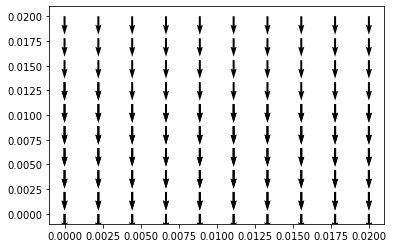

In [73]:
#fluxes
dT=np.zeros((len(cells),2))
q=np.zeros((len(cells),2))
kvec=np.array([[401,0],[0,401]])
for i in range(len(cells)):
    x1,x2,x3=points[cells[i]][0][0],points[cells[i]][1][0],points[cells[i]][2][0]
    y1,y2,y3=points[cells[i]][0][1],points[cells[i]][1][1],points[cells[i]][2][1]
    b1,b2,b3=y2-y3,y3-y1,y1-y2
    c1,c2,c3=x3-x2,x1-x3,x2-x1
    delta=(x1*b1+x2*b2+x3*b3)/2
    bc=np.array([[b1,b2,b3],[c1,c2,c3]])
    temps=np.array([T[cells[i][0]],T[cells[i][1]],T[cells[i][2]]])
    vector=np.array(bc@temps/(2*delta))
    dT[i]=vector
    q[i]=-kvec@vector

plt.quiver(points[:,0],points[:,1],dT[:,0],dT[:,1])

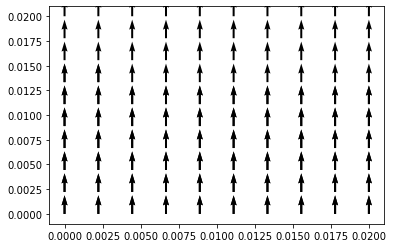

In [74]:
plt.quiver(points[:,0],points[:,1],q[:,0],q[:,1])